In [1]:
from tqdm.notebook import trange
import numpy as np
from scipy.ndimage import convolve

In [2]:
#Random number generator that outputs uniformly distributed floats in the range [0,1)
rng = np.random.default_rng()

<h1>Assignment 2:</h1>

<h2>Simulation:</h2>

<h3>Calculating the parameters:</h3>

The Hamiltonian is given by $$H = -J \sum_{\left\langle ij \right\rangle}{s_i s_j}$$ where $s_i \in \{+1,-1\}$.

We need to find a suitable value of $J$ such that the critical temperature $T_c$ as given by the mean field theory approximation is $2$. The relation between $J$ and $T_c$ in the mean field theory approximation is given as $JC\beta_c = \frac{JC}{kT_c}=1$ where $C=4$ for the 2D Ising model. We will define our units such that $k=2$. This conveniently gives us $J=1$.

We will consider periodic boundary conditions.

<h3>Monte-Carlo step:</h3>

The spin-up state is taken as $+1$ and the spin-down state is taken as $-1$.

In one Monte-Carlo step, we flip the state of one spin and calculate the resulting energy difference $\Delta E = E_f - E_i$. When a spin is flipped, only $4$ terms are affected in the Hamiltonian, and they are the interactions between the nearest neighbour spins of the flipped spin and the flipped spin itself. So, instead of recalculating the entire Hamiltonian every time, we can simply calculate the energy difference from these $4$ terms.

Let us say spin $s_{(i,j)}$ was flipped (which is the spin at row $i$ and column $j$). The energy difference is then $$\Delta E = 2Js_{(i,j)} \cdot \left( s_{(i+1,j)} + s_{(i,j+1)} + s_{(i-1,j)} + s_{(i,j-1)} \right)$$ since we just flipped the sign of these $4$ terms. Note that the indices are considered modulo $N$ because of periodic boundary conditions.

Then we can test if the new state satisfies our conditions and if it does, we'll flip the spin.

<h3>Speeding up the simulation:</h3>

If we consider the lattices for fixed $N$, in each timestep we are performing basically the same operation on all of them, and each step follows the same sequence of spins. So instead of evolving them one by one, we can process all of them at the same time. NumPy does this effectively through "vectorization". In general, the goal is to remove as much explicit looping as possible and pass on as much work as possible to library functions (which are highly optimised and written in a lower-level language like C). In the following code, I have used this idea.

Instead of passing one lattice-temperature pair, I have passed lists of lattice-temperature pairs. Now, in each step, I can calculate $\Delta E$, whether the state was accepted, and flipping the spin if the state was accepted, for all of the lattices in one go. We have to keep $N$ fixed, otherwise the array indexing would get messed up when calculating $\Delta E$.

Let's look at our acceptance criteria. We accept a state if

$$X \leq \exp{\left(-\frac{\Delta E}{kT}\right)}$$

where $X$ is a random variable uniformly distributed in $[0,1)$. We can notice that $J=1$ so we can forget about it. There is a factor of $2$ in $\Delta E$ and $k=2$. These cancel, so we can forget about them. Now there are $3$ parts to our expression, the value of the current cell, the sum of neigbouring cells, and $X$. Let us transform the expression to

$$-T\ln{X} \geq s_{(i,j)} \cdot \left( s_{(i+1,j)} + s_{(i,j+1)} + s_{(i-1,j)} + s_{(i,j-1)} \right)$$

Now we can show that $Y=-T\ln{X}$ is distributed as an exponential distribution with mean $T$ ([see here](https://math.stackexchange.com/questions/199614/distribution-of-log-x-if-x-is-uniform)). This way we can generate a batch of random numbers by passing the list of $T$ values in one call. Also, the sum of neighbouring cells can conveniently be calculating by convolving the lattice with a mask using SciPy.

Finally, we can remove more explicit looping over cells. Imagine we have a lattice of even size. Colour it like a chessboard. Now notice that by the nature of the nearest-neighbour sum, white cells only depend on the values of black cells and vice versa. Which means that we can process the values of all white cells at once! Then we can recalculate and similarly process all black cells at once. If the lattice has odd size then we can do the above excluding the last row and column, and process those separately.

In [3]:
def mc_timestep_even(lattices,Ts_scale,nn_mask,black_mask,white_mask):
    rand = rng.exponential(scale=Ts_scale,size=lattices.shape)
    rand_black = rand*black_mask
    rand_white = rand*white_mask
    #Black
    del_Es = lattices*np.array([convolve(lattice,nn_mask,mode='wrap') for lattice in lattices])
    del_Es_black = del_Es*black_mask
    rejects_black = del_Es_black - rand_black + white_mask
    lattices *= np.sign(rejects_black).astype(np.int8)
    #White
    del_Es = lattices*np.array([convolve(lattice,nn_mask,mode='wrap') for lattice in lattices])
    del_Es_white = del_Es*white_mask
    rejects_white = del_Es_white - rand_white + black_mask
    lattices *= np.sign(rejects_white).astype(np.int8)

In [4]:
def mc_timestep_odd(lattices,Ts_scale,nn_mask,black_mask,white_mask):
    rand = rng.exponential(scale=Ts_scale,size=lattices.shape)
    rand_black = rand[:,:-1,:-1]*black_mask
    rand_white = rand[:,:-1,:-1]*white_mask
    #Black
    del_Es = lattices[:,:-1,:-1]*np.array([convolve(lattice,nn_mask,mode='wrap') for lattice in lattices])[:,:-1,:-1]
    del_Es_black = del_Es*black_mask
    rejects_black = del_Es_black - rand_black + white_mask
    lattices[:,:-1,:-1] *= np.sign(rejects_black).astype(np.int8)
    #White
    del_Es = lattices[:,:-1,:-1]*np.array([convolve(lattice,nn_mask,mode='wrap') for lattice in lattices])[:,:-1,:-1]
    del_Es_white = del_Es*white_mask
    rejects_white = del_Es_white - rand_white + black_mask
    lattices[:,:-1,:-1] *= np.sign(rejects_white).astype(np.int8)
    #Process last row and column normally
    for i in range(N-1):
        del_E = lattices[:,i,N-1]*(lattices[:,i-1,N-1]+lattices[:,i+1-N,N-1]+lattices[:,i,N-2]+lattices[:,i,0])
        reject = del_E - rand[:,i,N-1]
        lattices[:,i,N-1] *= np.sign(reject).astype(np.int8)
    for j in range(N):
        del_E = lattices[:,N-1,j]*(lattices[:,N-1,j-1]+lattices[:,N-1,j+1-N]+lattices[:,N-2,j]+lattices[:,0,j])
        reject = del_E - rand[:,N-1,j]
        lattices[:,i,N-1] *= np.sign(reject).astype(np.int8)

<h3>Simulating and gathering snapshots:</h3>

The following cells define the required elements of the simulation and then we run it. We take an $N \times N$ sized lattice at temperature $T$. For the initial state, we'll consider all spins to point up. First it is allowed to equilibriate for ```t_equilibrium``` timesteps, then ```snapshot_count``` snapshots are gathered every ```snapshot_interval``` timesteps.

Then the snapshots are stored in ```.npz``` format for further analysis. This way, we have to run the simulation just once, and later we can use the stored data anytime.

In [5]:
def simulate(N,Ts,equilibriation_time,autocorrelation_time,snapshot_count):
    #Create lattices
    lattices = np.ones(shape=(Ts.shape[0],N,N),dtype=np.int8)
    Ts_scale = np.array([T*np.ones(shape=(N,N)) for T in Ts])
    nn_mask = np.array([[0,1,0],
                        [1,0,1],
                        [0,1,0]]).astype(np.int8)
    black_mask = np.tile([[1,0],[0,1]],(Ts.shape[0],N//2,N//2)).astype(np.int8)
    white_mask = np.tile([[0,1],[1,0]],(Ts.shape[0],N//2,N//2)).astype(np.int8)
    timestep_method = None
    if N%2 == 0:
      timestep_method = mc_timestep_even
    else:
      timestep_method = mc_timestep_odd

    #Allow lattices to equilibriate
    for t in trange(equilibriation_time,desc='Equilibriation'):
        timestep_method(lattices,Ts_scale,nn_mask,black_mask,white_mask)

    #Collect snapshots
    snapshots = np.empty((snapshot_count,*lattices.shape),dtype=np.int8)
    for i in trange(snapshot_count,desc='Collecting snapshots'):
        for t in range(autocorrelation_time):
            timestep_method(lattices,Ts_scale,nn_mask,black_mask,white_mask)
        snapshots[i] = lattices

    temp_ordered_snaps = np.moveaxis(snapshots,1,0)
    np.savez_compressed(f'data_{N}.npz',*temp_ordered_snaps)

In [6]:
#Set the parameters here
t_equilibrium = 10000 #Equilibriation time
snapshot_interval = 100 #Autocorrelation time
snapshot_count = 1000 #Number of snapshots
T_list = np.linspace(0.1,4,40) #List of temperatures to compute for
N = 40 #Lattice size

In [7]:
#Run this cell to generate the data
print(f'Processing N = {N}...')
simulate(N,T_list,t_equilibrium,snapshot_interval,snapshot_count)

Processing N = 40...


Equilibriation:   0%|          | 0/10000 [00:00<?, ?it/s]

---

<h2>Analysis:</h2>

In [8]:
import matplotlib.pyplot as plt

<h3>How the data is stored:</h3>

All the data for a lattice of size $N \times N$ is stored in a file named ```data_{N}.npz```. The structure of the file is a list of sets of snapshots ordered in increasing value of temperature. See below for an example on how to access the data. Currently all the data uses the following parameters:

- ```t_equilibrium = 10000```
- ```snapshot_interval = 100```
- ```snapshot_count = 1000```
- ```T_list = np.linspace(0.1,4,40)```

<h3>Magnetisation:</h3>

In [9]:
def get_mag(filename,N,snapshot_count,T_count):
    temps = np.load(filename)
    magnetisation = np.zeros(T_count)
    temp_count = 0
    for _,temp in temps.items():
        mag_config = np.zeros(snapshot_count)
        snap_count = 0
        for snap in temp:
            mag_config[snap_count] = np.mean(snap)
            snap_count += 1
        magnetisation[temp_count] = np.mean(np.abs(mag_config))
        temp_count += 1
    return magnetisation

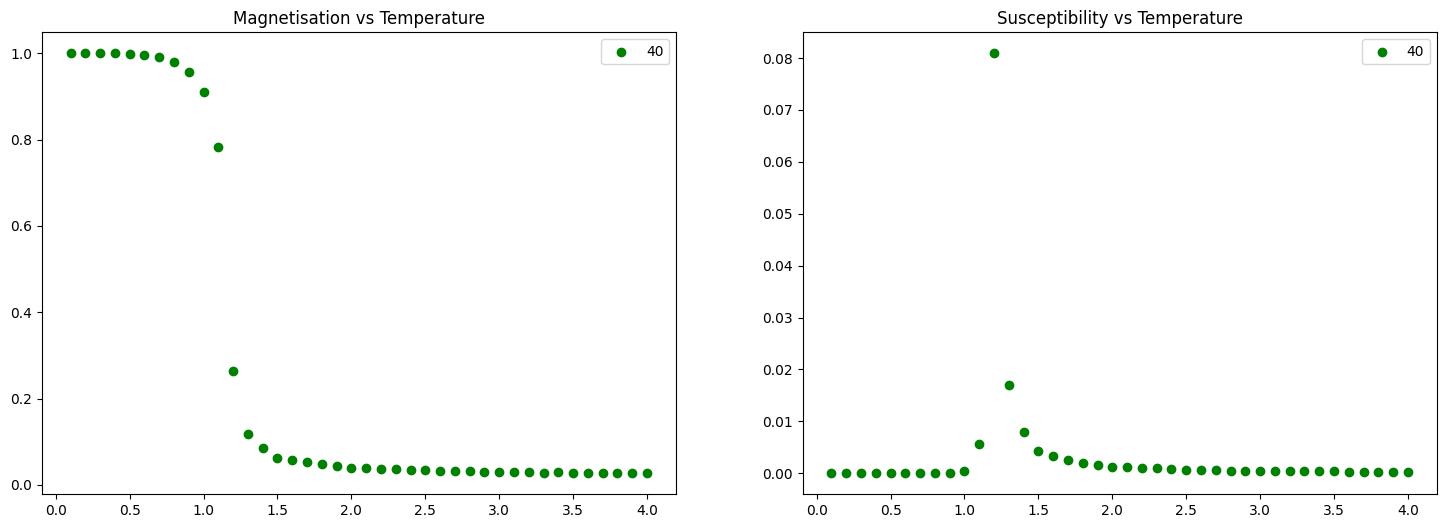

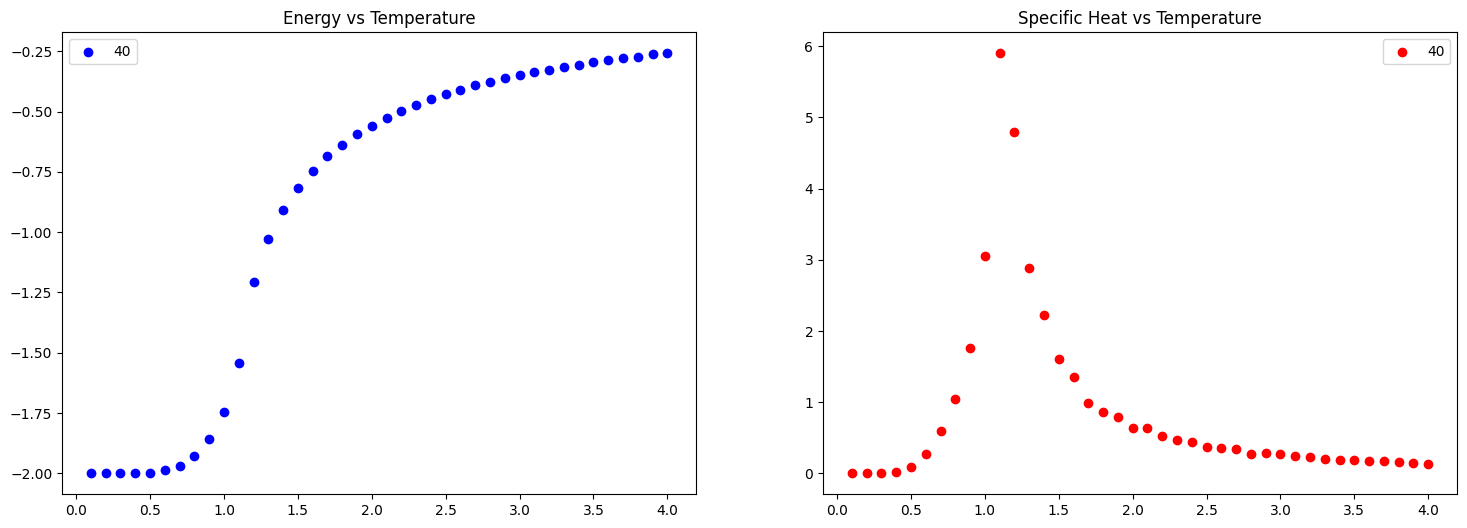

In [27]:
def get_susceptibility(filename, N, snapshot_count, T_count):
    temps = np.load(filename)
    susceptibility = np.zeros(T_count)
    temp_count = 0
    for _, temp in temps.items():
        mag_config = np.zeros(snapshot_count)
        snap_count = 0
        for snap in temp:
            mag_config[snap_count] = np.mean(snap)
            snap_count += 1
        susceptibility[temp_count] = np.var(mag_config) / T_list[temp_count]
        temp_count += 1
    return susceptibility

def get_energy(filename, N, snapshot_count, T_count):
    temps = np.load(filename)
    energy = np.zeros(T_count)
    temp_count = 0
    for _, temp in temps.items():
        energy_config = np.zeros(snapshot_count)
        snap_count = 0
        for snap in temp:
            energy_config[snap_count] = -np.sum(snap * np.roll(snap, shift=-1, axis=0) + snap * np.roll(snap, shift=-1, axis=1))
            snap_count += 1
        energy[temp_count] = np.mean(energy_config) / (N * N)
        temp_count += 1
    return energy

def get_specific_heat(filename, N, snapshot_count, T_count):
    temps = np.load(filename)
    specific_heat = np.zeros(T_count)
    temp_count = 0
    for _, temp in temps.items():
        energy_config = np.zeros(snapshot_count)
        snap_count = 0
        for snap in temp:
            energy_config[snap_count] = -np.sum(snap * np.roll(snap, shift=-1, axis=0) + snap * np.roll(snap, shift=-1, axis=1))
            snap_count += 1
        specific_heat[temp_count] = (np.var(energy_config) / (T_list[temp_count] ** 2)) / (N * N)
        temp_count += 1
    return specific_heat

# Calculate quantities
magnetisation_40_new = get_mag('data_40.npz',40,1000,40)
susceptibility_40_new = get_susceptibility('data_40.npz', 40, 1000, 40)
energy_40_new = get_energy('data_40.npz', 40, 1000, 40)
specific_heat_40_new = get_specific_heat('data_40.npz', 40, 1000, 40)

# Plot quantities
plt.figure(figsize=(18, 6))

plt.subplot(121)
plt.scatter(T_list,magnetisation_40_new,c='green',label='40')
plt.title('Magnetisation vs Temperature')
plt.legend()

plt.subplot(122)
plt.scatter(T_list,susceptibility_40_new,c='green',label='40')
plt.title('Susceptibility vs Temperature')
plt.legend()

plt.show()

plt.figure(figsize=(18, 6))

plt.subplot(121)
plt.scatter(T_list,energy_40_new,c='blue',label='40')
plt.title('Energy vs Temperature')
plt.legend()

plt.subplot(122)
plt.scatter(T_list,specific_heat_40_new,c='red',label='40')
plt.title('Specific Heat vs Temperature')
plt.legend()

plt.show()